# **Waze Project**

### Machine Learning Models

Let's build a machine learning model to predict user churn. we use two tree-based models: random forest and XGBoost.

In [82]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils import resample

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, \
ConfusionMatrixDisplay, classification_report, RocCurveDisplay, PrecisionRecallDisplay

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle as pkl

In [2]:
# Import dataset
df0 = pd.read_csv('C:\\Users\\mukhe\\Desktop\\Data_Analytics\\Projects\\Datasets\\waze_dataset.csv')

In [3]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


### **Feature engineering**

In [4]:
# Copy the df0 dataframe
df = df0.copy()

In [5]:
# Get the basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

Create a feature representing the mean number of kilometers driven on each driving day in the last month for each user.

In [6]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives']/df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [7]:
# 1. Convert infinite values to zero
df[df['km_per_driving_day'] == np.inf] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

In [8]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions']/df['total_sessions']

# 1. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    13975.000000
mean         0.449573
std          0.286996
min          0.000000
25%          0.196179
50%          0.424088
75%          0.687855
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

Create a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives and drove on 15+ days in the last month.

In [9]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives']>=60) & (df['activity_days']>=15), 1,0)

#### **`total_sessions_per_day`**

Now, create a new column that represents the mean number of sessions per day _since onboarding_.

In [10]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions']/df['n_days_after_onboarding']

In [11]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    13975.000000
mean         0.341241
std          1.311070
min          0.000298
25%          0.050987
50%          0.101053
75%          0.216694
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Create a column representing the mean kilometers per hour driven in the last month.

In [12]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives']/(df['duration_minutes_drives']/60)

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user.

In [13]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives']/df['drives']

# Descriptive stats
df['km_per_drive'].describe()

count    1.397500e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.313197e+01
50%      7.461603e+01
75%      1.850480e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

In [14]:
# 1. Convert infinite values to zero
df[df['km_per_drive'] == np.inf] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    13975.000000
mean       233.476375
std        627.495672
min          0.000000
25%         32.221907
50%         72.606220
75%        179.254178
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. 

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [15]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2'])/df['total_sessions']

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    13876.000000
mean         1.617784
std          7.584354
min          0.000000
25%          0.207371
50%          0.646569
75%          1.639192
max        777.563629
Name: percent_of_sessions_to_favorite, dtype: float64

### **Drop missing values**

The 700 missing values in the `label` column comprise less than 5% of the data. Therefore, it's safe to drop those values.

In [16]:
# Drop rows with missing values
df = df.dropna(axis=0).reset_index(drop=True)

### **Outliers**

We know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Data Preprocessing**

In [17]:
# Create new `device2` variable
encoder = OneHotEncoder(sparse_output=False, drop='first', dtype=int)
df['device2'] = encoder.fit_transform(df[['device']])
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0


#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained."

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

In [18]:
# Create binary `label2` column
df['label2'] = np.where((df['label']=='churned'), 1, 0)
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,percent_of_sessions_to_favorite,device2,label2
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058,0.700931,0,0
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173,0.253903,1,0
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567,0.000000,0,0
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778,4.867640,1,0
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206,1.016363,0,0


### **Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

Note, however, that `device` won't be used simply because it's a copy of `device2`.

In [19]:
# Drop `ID` column
df1 = df.copy()

df1 = df1.drop(columns=['ID', 'label', 'device'])

### **Evaluation metric**

Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

In [20]:
# Get class balance of 'label' col
df1['label2'].value_counts(normalize=True)

label2
0    0.838817
1    0.161183
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, consider which evaluation metric is best. Accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the **recall** score.

In [20]:
# 1. Isolate X variables
X = df1.drop(columns=['label2'], axis=1)

# 2. Isolate y variable
y = df1['label2']

# 3. Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

# 4. Split into train and validate sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=0)

In [21]:
# shape of all the paritioned data
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((10576, 18),
 (10576,),
 (2645, 18),
 (2645,),
 (7932, 18),
 (7932,),
 (2644, 18),
 (2644,))

This aligns with expectations.

### **Modeling**

#### **Random forest**

In [24]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth':[4, 10, None],
             'max_features':[0.5, 1.0],
             'max_samples':[0.5, 1.0],
             'min_samples_leaf':[2, 10],
             'min_samples_split':[2, 10],
             'n_estimators':[100, 150]}

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf,
                     cv_params,
                     scoring=scoring,
                     cv=5,
                     refit='recall',
                     n_jobs=-1)

Now fit the model to the training data.

In [25]:
%%time
rf_cv.fit(X_tr, y_tr)

CPU times: total: 34.1 s
Wall time: 17min 59s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 10, None], 'max_features': [0.5, 1.0],
                         'max_samples': [0.5, 1.0], 'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 150]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [26]:
# helper functions to write and read pickle
def write_pickle(path, model_object, save_name:str):
    '''
    Function to store fit model as binary file
    Arguments:
        path: filepath
        model_object: trained model
        save_name: string name to store
    '''
    with open(path + save_name + '.pkl', 'wb') as to_write:
        pkl.dump(model_object, to_write)
        
def read_pickle(path, saved_model_name:str):
    '''
    Function to load saved fit model
    Arguments:
        path: filepath
        saved_model_name: String name with which the model was saved
    '''
    with open(path + saved_model_name + '.pkl', 'rb') as to_read:
        model = pkl.load(to_read)
    return model

In [27]:
# Define the path
path = 'C:\\Users\\mukhe\\Desktop\\Data_Analytics\\Projects\\Python_Pickle_files\\'

In [28]:
# save the trained model as a binary file
write_pickle(path, rf_cv, 'waze_rf_cv')

In [29]:
# read back the saved model object
rf_cv = read_pickle(path, 'waze_rf_cv')

In [30]:
# Examine best score
rf_cv.best_score_

0.10866421568627452

In [31]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [32]:
def make_results(model_name:str, model_object, metric:str):
    
    '''
    Helper function to convert results to dataframe
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

  # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'accuracy':'mean_test_accuracy',
                 'precision':'mean_test_precision',
                 'recall':'mean_test_recall',
                 'f1':'mean_test_f1'}

  # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

  # Isolate the row of the df with the max(metric) score
    best_values = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

  # Extract Accuracy, precision, recall, and f1 score from that row
    accuracy = best_values.mean_test_accuracy
    precision = best_values.mean_test_precision
    recall = best_values.mean_test_recall
    f1 = best_values.mean_test_f1
    

  # Create table of results
    table = pd.DataFrame({'Model':[model_name],
                          'Precision':[precision],
                          'Recall':[recall],
                          'F1':[f1],
                          'Accuracy':[accuracy]})
    return table
  

In [33]:
rf_results = make_results('RandomForest_CV', rf_cv, 'recall')
rf_results

,Model,Precision,Recall,F1,Accuracy
0,RandomForest_CV,0.468348,0.108664,0.176255,0.836359


Asside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last course the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

#### **XGBoost**

In [55]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# 2. Create a dictionary of hyperparameters to tune
xgb_params = {'max_depth':[4, 10, None],
              'min_child_weight':[5, 8, 10],
              'learning_rate':[0.1, 0.3],
              'n_estimators':[100, 300]}

# 3. Define a list of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1']

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb,
                      xgb_params,
                      scoring=scoring,
                      cv=5,
                      refit='recall',
                      n_jobs=-1)

In [56]:
%%time
xgb_cv.fit(X_tr, y_tr)

CPU times: total: 33.4 s
Wall time: 2min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3],
                         'max_depth': [4, 10, None],
                         'min_child_weight': [5, 8, 10],
                         'n_estimators': [100, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [57]:
# save the trained model
write_pickle(path, xgb_cv, 'waze_xgb_cv')

In [58]:
# read the saved model
xgb_cv = read_pickle(path, 'waze_xgb_cv')

In [59]:
# Examine best score
xgb_cv.best_score_

0.1696875

In [60]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_weight': 10,
 'n_estimators': 300}

In [61]:
# Call 'make_results()' on the GridSearch object
xgb_results = make_results('XGBoost_CV', xgb_cv, 'recall')
results = pd.concat([rf_results, xgb_results], axis=0)
results

,Model,Precision,Recall,F1,Accuracy
0,RandomForest_CV,0.468348,0.108664,0.176255,0.836359
0,XGBoost_CV,0.365698,0.169687,0.231528,0.818961


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Model selection**

Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [62]:
# Use random forest model to predict on validation data
rf_preds_val = rf_cv.best_estimator_.predict(X_val)

In [63]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'Model': [model_name],
                          'Precision': [precision],
                          'Recall': [recall],
                          'F1': [f1],
                          'Accuracy': [accuracy]
                          })

    return table

In [64]:
# Get validation scores for RF model
rf_results_val = get_test_scores('RandomForest_CV_val', rf_preds_val, y_val)

# Append to the results table
results = pd.concat([rf_results_val, results], axis=0)
results

,Model,Precision,Recall,F1,Accuracy
0,RandomForest_CV_val,0.482353,0.096244,0.160470,0.837746
0,RandomForest_CV,0.468348,0.108664,0.176255,0.836359
0,XGBoost_CV,0.365698,0.169687,0.231528,0.818961


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

In [65]:
# Use XGBoost model to predict on validation data
xgb_preds_val = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_results_val = get_test_scores('XGBoost_CV_val', xgb_preds_val, y_val)

# Append to the results table
results = pd.concat([xgb_results_val, results], axis=0)
results

,Model,Precision,Recall,F1,Accuracy
0,XGBoost_CV_val,0.366667,0.154930,0.217822,0.820726
0,RandomForest_CV_val,0.482353,0.096244,0.160470,0.837746
0,RandomForest_CV,0.468348,0.108664,0.176255,0.836359
0,XGBoost_CV,0.365698,0.169687,0.231528,0.818961


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

### **Use champion model to predict on test data**

Now, use the champion model to predict on the test dataset. This is to give a final indication of how we should expect the model to perform on new future data, should you decide to use the model.

In [66]:
# Use XGBoost model to predict on test data
xgb_preds_test = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_results_test = get_test_scores('XGBoost_CV_test', xgb_preds_test, y_test)

# Append to the results table
final_results = pd.concat([xgb_results_test, results], axis=0)
final_results

,Model,Precision,Recall,F1,Accuracy
0,XGBoost_CV_test,0.324468,0.143192,0.198697,0.813989
0,XGBoost_CV_val,0.366667,0.154930,0.217822,0.820726
0,RandomForest_CV_val,0.482353,0.096244,0.160470,0.837746
0,RandomForest_CV,0.468348,0.108664,0.176255,0.836359
0,XGBoost_CV,0.365698,0.169687,0.231528,0.818961


The recall was exactly the same as it was on the validation data, but the precision declined notably, which caused all of the other scores to drop slightly. Nonetheless, this is stil within the acceptable range for performance discrepancy between validation and test scores.

### **Confusion matrix**

Plot a confusion matrix of the champion model's predictions on the test data.

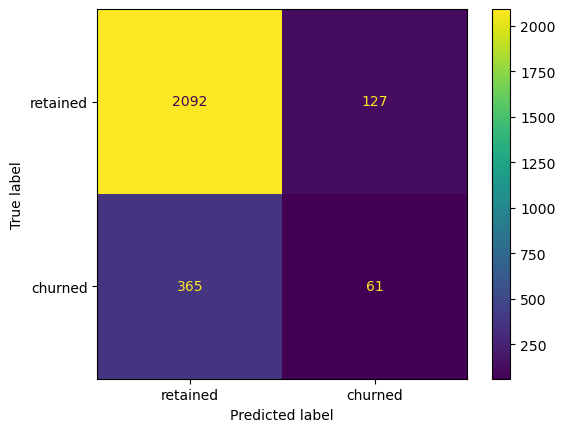

In [67]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_preds_test, labels=xgb_cv.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])

# Plot confusion matrix
disp.plot(values_format='')
plt.show()

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 16.6% of the users who actually churned.

### **Feature importance**

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

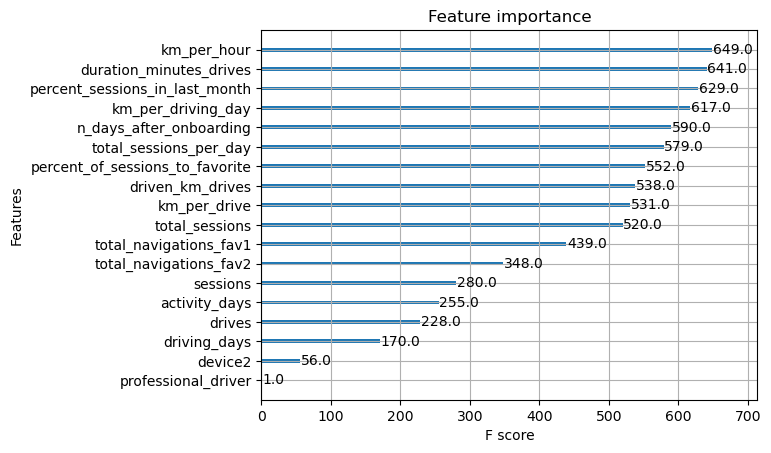

In [68]:
plot_importance(xgb_cv.best_estimator_)

The XGBoost model made more use of many of the features than did the logistic regression model from the previous course, which weighted a single feature (`activity_days`) very heavily in its final prediction.

Notice that engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, note that the important features in one model might not be the same as the important features in another model. That's why we shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.

### **Identify an optimal decision threshold**

The default decision threshold for most implementations of classification algorithms - including scikit-learn's is 0.5. This means that, in the case of the Waze models, if they predicted that a given user had a 50% probability or greater of churning, then that user was assigned a predicted value of `1` - the user was predicted to churn.

With imbalanced datasets where the response class is a minority, this threshold might not be ideal. We can plot a precision-recall curve which can help to visualize the trade-off between the model's precision and recall.

Here's the precision-recall curve for the XGBoost champion model on the test data.

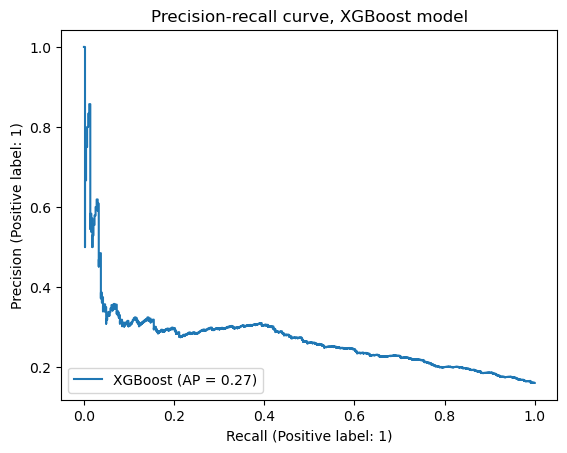

In [69]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(xgb_cv.best_estimator_, X_test, y_test, name='XGBoost')
plt.title('Precision-recall curve, XGBoost model');

As recall increases, precision decreases. But what if you determined that false positives aren't much of a problem? For example, in the case of this Waze project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.

So, we could tweak the decision threshold to slightly improve the model's performance.

In [70]:
# Get predicted probabilities on the test data
xgb_proba = xgb_cv.best_estimator_.predict_proba(X_test)
xgb_proba

array([[0.98328733, 0.01671265],
       [0.99762917, 0.00237083],
       [0.7892146 , 0.21078537],
       ...,
       [0.9625692 , 0.03743083],
       [0.93092775, 0.06907222],
       [0.91091233, 0.08908767]], dtype=float32)

In [71]:
# Create a list of just the second column values (probability of target)
xgb_churned_proba = xgb_proba[:,-1]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
xgb_new_preds = [1 if x >= 0.4 else 0 for x in xgb_churned_proba]

In [72]:
# Get evaluation metrics for when the threshold is 0.4
print('Precision:',precision_score(y_test, xgb_new_preds))
print('Recall:',recall_score(y_test, xgb_new_preds))
print('F1:',f1_score(y_test, xgb_new_preds))
print('Accuracy:',accuracy_score(y_test, xgb_new_preds))

Precision: 0.2891566265060241
Recall: 0.16901408450704225
F1: 0.21333333333333335
Accuracy: 0.7992438563327032


Compare these numbers with the results from earlier.

In [73]:
xgb_new_scores = get_test_scores('XGBoost_new', xgb_new_preds, y_test)
final_results = pd.concat([xgb_new_scores, final_results], axis=0)
final_results

,Model,Precision,Recall,F1,Accuracy
0,XGBoost_new,0.289157,0.169014,0.213333,0.799244
0,XGBoost_CV_test,0.324468,0.143192,0.198697,0.813989
0,XGBoost_CV_val,0.366667,0.154930,0.217822,0.820726
0,RandomForest_CV_val,0.482353,0.096244,0.160470,0.837746
0,RandomForest_CV,0.468348,0.108664,0.176255,0.836359
0,XGBoost_CV,0.365698,0.169687,0.231528,0.818961


Recall and F1 score increased significantly, while precision and accuracy decreased.

So, using the precision-recall curve as a guide, suppose if the model had a recall score of 0.5 and we were willing to accept the ~30% precision score that comes with it. In other words, we'd be happy if the model successfully identified half of the people who will actually churn, even if it means that when the model says someone will churn, it's only correct about ~30% of the time.

In [74]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


In [79]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(0.083, 0.5046948356807511)

Setting a threshold of 0.083 will result in a recall of 0.504.

In [80]:
# Create an array of new predictions that assigns a 1 to any value >= 0.083
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.083 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.083
get_test_scores('XGB, threshold = 0.083', new_preds, y_test)

,Model,Precision,Recall,F1,Accuracy
0,"XGB, threshold = 0.083",0.261557,0.504695,0.344551,0.690737


It worked! Therefore, by tweaking the decision threshold we could obtain the required results.

### Rebalance the target class to check for performance improvement

In [81]:
# Check the class balance
df1['label2'].value_counts(normalize=True)

0    0.838817
1    0.161183
Name: label2, dtype: float64

In [86]:
# Use the upsampling technique to balance the target class

# Identify majority and minority classes
majority_class = df1[df1['label2']==0]
minority_class = df1[df1['label2']==1]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,
                              n_samples=len(majority_class),
                              random_state=0)

# Combine the majority class with the upsampled minority class
df_upsampled = pd.concat([majority_class, minority_upsampled]).reset_index(drop=True)

# Shape of the data
print('Shape of the upsampled data:',df_upsampled.shape)

# Check the class balance
df_upsampled['label2'].value_counts(normalize=True)

Shape of the upsampled data: (22180, 19)


0    0.5
1    0.5
Name: label2, dtype: float64

After upsampling the data there are 22180 records in total.

#### Split the balanced data

In [87]:
# 1. Isolate X variables
X1 = df_upsampled.drop(columns=['label2'], axis=1)

# 2. Isolate y variable
y1 = df_upsampled['label2']

# 3. Split into train and test sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, stratify=y1, random_state=0)

# 4. Split into train and validate sets
X1_tr, X1_val, y1_tr, y1_val = train_test_split(X1_train, y1_train, test_size=0.25, stratify=y1_train, random_state=0)

In [88]:
# shape of all the paritioned data
X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape, X1_tr.shape, y1_tr.shape, X1_val.shape, y1_val.shape

((17744, 18),
 (17744,),
 (4436, 18),
 (4436,),
 (13308, 18),
 (13308,),
 (4436, 18),
 (4436,))

### Modelling

#### Random Forest

In [89]:
# Instantiate the Grid Search object 
rf_cv_up = GridSearchCV(rf,
                     cv_params,
                     scoring=scoring,
                     cv=5,
                     refit='recall',
                     n_jobs=-1)

Fit the model with upsampled data

In [91]:
%%time
rf_cv_up.fit(X1_tr, y1_tr)

CPU times: total: 1min 6s
Wall time: 28min 27s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [4, 10, None], 'max_features': [0.5, 1.0],
                         'max_samples': [0.5, 1.0], 'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 150]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [92]:
# save the trained model
write_pickle(path, rf_cv_up, 'waze_rf_cv_up')

In [93]:
# read the saved model
rf_cv_up = read_pickle(path, 'waze_rf_cv_up')

In [94]:
# View best score
rf_cv_up.best_score_

0.9446938533410913

In [95]:
# View best params combination
rf_cv_up.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 150}

In [97]:
rf_up_results = make_results('RandomForest_CV_Up', rf_cv_up, 'recall')
rf_up_results

,Model,Precision,Recall,F1,Accuracy
0,RandomForest_CV_Up,0.850972,0.944694,0.89537,0.889614


We could see a 85% jump of the recall score of 0.94 of the upsampled dataset when compared to the original data (~0.10). All the other metrics are also above the bench mark levels of a decent model.

#### XGBoost

In [98]:
# Instantiate the GridSearchCV object
xgb_cv_up = GridSearchCV(xgb,
                      xgb_params,
                      scoring=scoring,
                      cv=5,
                      refit='recall',
                      n_jobs=-1)

Fit the upsampled data to the model object

In [99]:
%%time
xgb_cv_up.fit(X1_tr, y1_tr)

CPU times: total: 54.1 s
Wall time: 3min 23s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3],
                         'max_depth': [4, 10, None],
                         'min_child_weight': [5, 8, 10],
                         'n_estimators': [100, 300]},
             refit='recall', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [100]:
# save the trained model
write_pickle(path, xgb_cv_up, 'waze_xgb_cv_up')

In [101]:
# read the saved model
xgb_cv_up = read_pickle(path, 'waze_xgb_cv_up')

In [102]:
# View best score
xgb_cv_up.best_score_

0.9484502013862606

In [103]:
# View best params combination
xgb_cv_up.best_params_

{'learning_rate': 0.3,
 'max_depth': 10,
 'min_child_weight': 8,
 'n_estimators': 300}

In [104]:
xgb_up_results = make_results('XGBoost_CV_Up', xgb_cv_up, 'recall')
xgb_up_results

,Model,Precision,Recall,F1,Accuracy
0,XGBoost_CV_Up,0.848947,0.94845,0.895931,0.88984


The model performed slightly better than the random forest with improved recall score of 0.948.

In [106]:
# Combine the upsampled results
results_up = pd.concat([rf_up_results, xgb_up_results], axis=0)
results_up

,Model,Precision,Recall,F1,Accuracy
0,RandomForest_CV_Up,0.850972,0.944694,0.895370,0.889614
0,XGBoost_CV_Up,0.848947,0.948450,0.895931,0.889840


### Model Selection

Test the models on the validation set.

In [105]:
# Use random forest model to predict on validation data
rf_up_preds_val = rf_cv_up.best_estimator_.predict(X1_val)

In [107]:
# Get validation scores for upsampled RF model
rf_up_results_val = get_test_scores('RF_CV_Up_val', rf_up_preds_val, y1_val)

# Append to the results table
results_up = pd.concat([rf_up_results_val, results_up], axis=0)
results_up

,Model,Precision,Recall,F1,Accuracy
0,RF_CV_Up_val,0.892977,0.963030,0.926681,0.923805
0,RandomForest_CV_Up,0.850972,0.944694,0.895370,0.889614
0,XGBoost_CV_Up,0.848947,0.948450,0.895931,0.889840


#### XGBoost

In [108]:
# Use XGBoost model to predict on upsampled validation data
xgb_up_preds_val = xgb_cv_up.best_estimator_.predict(X1_val)

# Get validation scores for XGBoost model
xgb_up_results_val = get_test_scores('XGB_CV_Up_val', xgb_up_preds_val, y1_val)

# Append to the results table
results_up = pd.concat([xgb_up_results_val, results_up], axis=0)
results_up

,Model,Precision,Recall,F1,Accuracy
0,XGB_CV_Up_val,0.879592,0.971596,0.923308,0.919297
0,RF_CV_Up_val,0.892977,0.963030,0.926681,0.923805
0,RandomForest_CV_Up,0.850972,0.944694,0.895370,0.889614
0,XGBoost_CV_Up,0.848947,0.948450,0.895931,0.889840


XGBoost emerged as the champion model upon testing on the upsampled validation set.

### Use the champion model to test on upsampled test data

In [109]:
# Use XGBoost model to predict on test data
xgb_up_preds_test = xgb_cv_up.best_estimator_.predict(X1_test)

# Get test scores for XGBoost model
xgb_up_results_test = get_test_scores('XGB_CV_Up_test', xgb_up_preds_test, y1_test)

# Append to the results table
final_results_up = pd.concat([xgb_up_results_test, results_up], axis=0)
final_results_up

,Model,Precision,Recall,F1,Accuracy
0,XGB_CV_Up_test,0.866237,0.969342,0.914894,0.909829
0,XGB_CV_Up_val,0.879592,0.971596,0.923308,0.919297
0,RF_CV_Up_val,0.892977,0.963030,0.926681,0.923805
0,RandomForest_CV_Up,0.850972,0.944694,0.895370,0.889614
0,XGBoost_CV_Up,0.848947,0.948450,0.895931,0.889840


#### Plot the Confusion Matrix

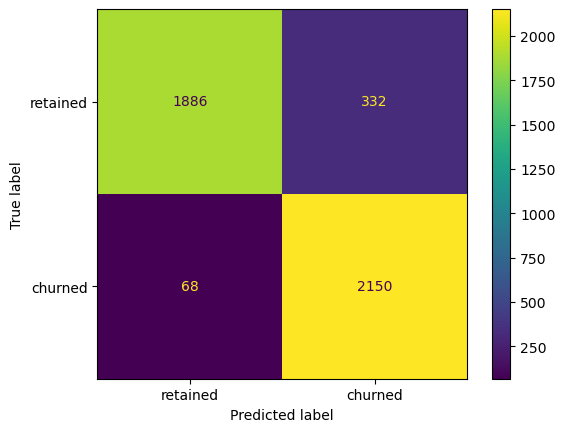

In [110]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y1_test, xgb_up_preds_test, labels=xgb_cv_up.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained', 'churned'])

# Plot confusion matrix
disp.plot(values_format='')
plt.show()

The model performed well on the upsampled data with only 68 false negatives which accounts to ~1.5% of the test data. The recall score of the model has greatly improved on the upsampled data indicating that more data from Waze would result in improved model performance.

## Conclusion

* The model yielded poor recall score on the original dataset.
* The rebalanced data produced great results with ~85% jump in the recall score. 
* Splitting the data into three sets will result in less data to train the model. However, the validation set helps select the champion model and the test set in only used on the champion model to test its efficiency.
* Unlike tree models, logistic regression model is easy to interpret and have sufficient evidence like coefficients to support the predictions.
* Ensemble based tree models requires zero to less data preprocessing and they can handle multicollinearity and outliers. Whereas, logistic regression has specific model assumptions before we could train the model.
* We could notice that there are more feature engineered features in the feature importance. Therefore, we could work on more feature engineering with some domain experts to improve model in better predictions.
* More data on the user usage of the app would be helpful in improving the model's performance.
* Based on the selected evaluation metric, we could tweak the decision threshold to obtain slightly improved results  noting that the other metric will be effected and it shouldn't cost the business.